In [24]:
from hyppo.ksample import KSample
from hyppo.independence import Dcorr
from combat import combat
import pandas as pd
import glob
import os
import graspy as gp
import numpy as np
from dask.distributed import Client, progress
import dask.dataframe as ddf
from scipy.stats import zscore, rankdata, mannwhitneyu
import copy
import math
import networkx as nx
from graspy.models import SIEMEstimator as siem
import re

In [21]:
def get_sub_pheno_dat(subid, scan, pheno_dat):
    matches = pheno_dat.index[pheno_dat["SUBID"] == int(subid)].tolist()
    match = np.min(matches)
    return(int(pheno_dat.iloc[match]["SEX"]))

def get_age_pheno_dat(subid, scan, pheno_dat):
    matches = pheno_dat.index[pheno_dat["SUBID"] == int(subid)].tolist()
    match = np.min(matches)
    return(int(pheno_dat.iloc[match]["AGE_AT_SCAN_1"]))

def apply_along_dataset(scs, dsets, fn):
    scs_xfmd = np.zeros(scs.shape)
    for dset in np.unique(dsets):
        scs_xfmd[dsets == dset,:] = np.apply_along_axis(fn, 0, scs[dsets == dset,:])
    return(scs_xfmd)

def apply_along_individual(scs, fn):
    scs_xfmd = np.zeros(scs.shape)

def zsc(x):
    x_ch = copy.deepcopy(x)
    if (np.var(x_ch) > 0):
        x_ch = (x_ch - np.mean(x_ch))/np.std(x_ch)
        return x_ch
    else:
        return np.zeros(x_ch.shape)

def ptr(x):
    x_ch = copy.deepcopy(x)
    nz = x[x != 0]
    x_rank = rankdata(nz)*2/(len(nz) + 1)
    x_ch[x_ch != 0] = x_rank
    if (np.min(x_ch) != np.max(x_ch)):
        x_ch = (x_ch - np.min(x_ch))/(np.max(x_ch) - np.min(x_ch))
    return(x_ch)

In [39]:
# path to directory produced by download_aws.sh
basepath = '/data/corr/m2g/fmri/'

# path to directory containing phenotypic annotations for download_aws.sh script
pheno_basepath = '/data/corr/phenotypic/CoRR_AggregatedPhenotypicData.csv'
pheno_dat = pd.read_csv(pheno_basepath)
datasets = os.listdir(basepath)
print(datasets)

['IBATRT', 'Utah1', 'BMB_1', 'IPCAS_2', 'ABIDEII-TCD_1', 'SWU1', 'UWM', 'BNU2', 'XHCUMS', 'SWU4', 'IPCAS_3', 'ABIDEII-SDSU_1', 'SWU3', 'IPCAS_4', 'NYU_2', 'IPCAS_1', 'IPCAS_7', 'UPSM_1', 'ABIDEII-BNI_1', 'IACAS_1', 'IPCAS_5', 'NYU_1', 'BNU1', 'MRN_1', 'BNU3', 'HNU1', 'SWU2', 'IPCAS_8', 'JHNU', 'IPCAS_6']


In [ ]:
fmri_dict = {}

for i, dataset in enumerate(datasets):
    try:
        dset_dir = os.path.join('{}{}'.format(basepath, dataset), '*.csv')
        files_ds = glob.glob(dset_dir)

        successes = len(files_ds)

        scans = []
        sexs = []
        ages = []
        ds_lab = []
        subjects = []
        subids = []
        sessions = []
        for f in files_ds:
            # obtain graph for this subject
            try:
                gr_dat = gp.utils.import_edgelist(f)
                scansub = re.split('-|_', os.path.basename(f))
                sex = get_sub_pheno_dat(scansub[1], scansub[3], pheno_dat)
                age = get_age_pheno_dat(scansub[1], scansub[3], pheno_dat)
                subid = "dataset-{}_sub-{}_ses-{}".format(dataset, scansub[1], scansub[3])
                scans.append(gr_dat)
                sexs.append(sex)
                ages.append(age)
                subjects.append(scansub[1])
                ds_lab.append(dataset)
                subids.append(subid)
                sessions.append(scansub[3])
            except Exception as e:
                successes -= 1

        if (successes < 5):
            raise ValueError("Dataset: {} does not have enough successes.".format(dataset))

        # add it in assuming there are enough unique files with metadata annotation
        scans = np.vstack(scans)
        fmri_dict[dataset] = {"Data": scans, "Subject": subjects, "Session": scans, "Subid": subids,
                              "Sex": sexs, "Age": ages, "Dataset": ds_lab}

    except Exception as e:
        print("Error in {} Dataset.".format(dataset))
        print(e)

In [47]:
len(fmri_dict)

26

In [35]:
ncores = 6
client = Client(threads_per_worker=1, n_workers=ncores)

/home/eric/.virtualenvs/batch/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34845 instead
  http_address["port"], self.http_server.port


## Preservation of Network Statistics

In [36]:
def diag_edges(n):
    """
    A function for generating diagonal SIEM edge communities.
    """
    m = int(n/2)
    edge_comm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if (i == j + m) or (j == i + m):
                edge_comm[i,j] = 1
            else:
                edge_comm[i,j] = 2
    return edge_comm

def modular_edges(n):
    """
    A function for generating modular sbm edge communities.
    """
    m = int(n/2)
    edge_comm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if ((i<m) & (j<m)) or ( (i>=m ) & (j>=m) ):
                edge_comm[i,j] = 1
            else:
                edge_comm[i,j] = 2   
    return edge_comm

des_diag = diag_edges(70)
des_mod = modular_edges(70)

def mww(G, C):
    A = G[C == 1]
    B = G[C == 2]
    return(mannwhitneyu(A, B, alternative='greater')[1])

In [48]:
dset_ls = [fmri_dict[ds]["Data"] for ds in fmri_dict.keys()]
raw_dat = np.vstack(dset_ls)
datasets = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Dataset"]])
# get the subject ids and dataset ids as a big list
subjects = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Subject"]])
sessions = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Session"]])
subids = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Subid"]])
sexs = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Sex"]])
ages = np.array([j for ds in fmri_dict.keys() for j in fmri_dict[ds]["Age"]])

def prepare_aggregate_data(scans, datasets):
    newdat = {}
    newdat["raw"] = copy.deepcopy(scans)
    # copy the raw data over
    newdat["zscore"] = copy.deepcopy(scans)
    newdat["ptr"] = copy.deepcopy(scans)
    newdat["combat"] = copy.deepcopy(scans)

    # remove stationary edges for combat
    combat_rem_edges = ~np.all(newdat["combat"] == 0, axis=0)

    # apply relevant transforms en-masse
    newdat["zscore"] = apply_along_dataset(newdat["zscore"], datasets, zscore)
    # replace nans with zeros
    newdat["zscore"][np.isnan(newdat["zscore"])] = 0
    newdat["ptr"] = apply_along_dataset(newdat["ptr"], datasets, ptr)
    newdat["combat"][:,combat_rem_edges] = np.array(combat(pd.DataFrame(newdat["combat"][:,combat_rem_edges].T), datasets, model=None, numerical_covariates=None)).T
    return(newdat)

data_preproc = {}
data_preproc["raw"] = prepare_aggregate_data(raw_dat, datasets)
data_preproc["ptr"] = prepare_aggregate_data(np.apply_along_axis(ptr, 1, raw_dat), datasets)

KeyError: 'Session'

In [20]:
exps = []

for i, sub in enumerate(subjects):
    sspl = sub.split('_')
    dset = sspl[0]
    for sxfm in ["raw", "ptr"]:
        for dxfm in ["raw", "zscore", "ptr", "combat"]:
            exps.append([dset, sspl[1], sspl[2], i, sub, sxfm, dxfm])
sim_exps = pd.DataFrame(exps, columns=["Dataset", "Subject", "Retest", "Ix", "Fullname", "Sxfm", "Dxfm"])
print(sim_exps.head(n=20))

   Dataset  Subject Retest  Ix         Fullname Sxfm    Dxfm
0    UPSM1  0025247      2   0  UPSM1_0025247_2  raw     raw
1    UPSM1  0025247      2   0  UPSM1_0025247_2  raw  zscore
2    UPSM1  0025247      2   0  UPSM1_0025247_2  raw     ptr
3    UPSM1  0025247      2   0  UPSM1_0025247_2  raw  combat
4    UPSM1  0025247      2   0  UPSM1_0025247_2  ptr     raw
5    UPSM1  0025247      2   0  UPSM1_0025247_2  ptr  zscore
6    UPSM1  0025247      2   0  UPSM1_0025247_2  ptr     ptr
7    UPSM1  0025247      2   0  UPSM1_0025247_2  ptr  combat
8    UPSM1  0025234      1   1  UPSM1_0025234_1  raw     raw
9    UPSM1  0025234      1   1  UPSM1_0025234_1  raw  zscore
10   UPSM1  0025234      1   1  UPSM1_0025234_1  raw     ptr
11   UPSM1  0025234      1   1  UPSM1_0025234_1  raw  combat
12   UPSM1  0025234      1   1  UPSM1_0025234_1  ptr     raw
13   UPSM1  0025234      1   1  UPSM1_0025234_1  ptr  zscore
14   UPSM1  0025234      1   1  UPSM1_0025234_1  ptr     ptr
15   UPSM1  0025234     

In [15]:
def singlegraph_exp(row):
    # grab data, and reshape it to nv x nv matrix
    flat_gr = data_preproc[row[5]][row[6]][subjects == row[4],:][0,:]
    nv = int(np.sqrt(np.max(flat_gr.shape)))
    exp_gr = flat_gr.reshape((nv, nv))
    G = nx.from_numpy_matrix(exp_gr)
    cc = nx.average_clustering(G, weight="weight")
    deg = np.array(list(dict(G.degree(weight="weight")).values())).mean()
    homophil_stat = mww(exp_gr, des_modular)
    homotop_stat = mww(exp_gr, des_diag)
    return(row[0], row[1], row[2], row[3], row[4], row[5], row[6], cc, deg, homophil_stat, homotop_stat)

In [16]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=ncores)
sim_results = sim_exps.apply(lambda x: singlegraph_exp(x), axis=1, result_type='expand',
                             meta={0: str, 1: str, 2: str, 3:str, 4:str, 5:str, 6:str,
                                   7: float, 8: float, 9: float, 10: float})
sim_results

,0,1,2,3,4,5,6,7,8,9,10
npartitions=99,,,,,,,,,,,
0,object,object,object,object,object,object,object,float64,float64,float64,float64
188,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
18424,...,...,...,...,...,...,...,...,...,...,...
18559,...,...,...,...,...,...,...,...,...,...,...


In [17]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Dataset", 1: "Subject", 2: "Retest", 3: "Ix",
                                          4: "Fullname", 5: "Sxfm", 6: "Dxfm", 7: "Clustering",
                                          8: "Degree", 9: "Homophilic", 10: "Homotopic"})
sim_results.to_csv('../data/summary/batch_statistics.csv')
sim_results.head(n=30)

,Dataset,Subject,Retest,Ix,Fullname,Sxfm,Dxfm,Clustering,Degree,Homophilic,Homotopic
0,UPSM1,0025247,2,0,UPSM1_0025247_2,raw,raw,0.166826+0.000000j,11.521252,0.984610,0.989099
1,UPSM1,0025247,2,0,UPSM1_0025247_2,raw,zscore,0.135565+0.070815j,-6.760357,0.829259,0.984094
2,UPSM1,0025247,2,0,UPSM1_0025247_2,raw,ptr,0.417197+0.000000j,33.296429,0.998218,0.966645
3,UPSM1,0025247,2,0,UPSM1_0025247_2,raw,combat,0.188979+0.001310j,13.061994,0.976177,0.993878
4,UPSM1,0025247,2,0,UPSM1_0025247_2,ptr,raw,0.425293+0.000000j,34.510715,0.984610,0.989099
5,UPSM1,0025247,2,0,UPSM1_0025247_2,ptr,zscore,0.235540+0.123174j,0.187067,0.939970,0.985495
6,UPSM1,0025247,2,0,UPSM1_0025247_2,ptr,ptr,0.429248+0.000000j,34.620310,0.997326,0.963562
7,UPSM1,0025247,2,0,UPSM1_0025247_2,ptr,combat,0.417906+0.003583j,34.760403,0.978920,0.992249
8,UPSM1,0025234,1,1,UPSM1_0025234_1,raw,raw,0.163197+0.000000j,12.214571,0.400550,0.592533
9,UPSM1,0025234,1,1,UPSM1_0025234_1,raw,zscore,0.116948+0.060277j,0.080530,0.015220,0.521666


In [ ]:

nv = int(np.sqrt(np.max(flat_gr.shape)))

In [19]:
flat_gr.shape

(2320, 4900)

In [ ]:
row[6]

['UPSM1', '0025247', '1', 2, 'UPSM1_0025247_1', 'ptr', 'raw']

array([[0.       , 0.160079 , 0.292451 , ..., 0.449895 , 0.056552 ,
        0.171077 ],
       [0.160079 , 0.       , 0.171617 , ..., 0.0893042, 0.0184389,
        0.452413 ],
       [0.292451 , 0.171617 , 0.       , ..., 0.233019 , 0.115388 ,
        0.125067 ],
       ...,
       [0.449895 , 0.0893042, 0.233019 , ..., 0.       , 0.0209164,
        0.0251454],
       [0.056552 , 0.0184389, 0.115388 , ..., 0.0209164, 0.       ,
        0.0603939],
       [0.171077 , 0.452413 , 0.125067 , ..., 0.0251454, 0.0603939,
        0.       ]])

array([[0.       , 0.160079 , 0.292451 , ..., 0.449895 , 0.056552 ,
        0.171077 ],
       [0.160079 , 0.       , 0.171617 , ..., 0.0893042, 0.0184389,
        0.452413 ],
       [0.292451 , 0.171617 , 0.       , ..., 0.233019 , 0.115388 ,
        0.125067 ],
       ...,
       [0.449895 , 0.0893042, 0.233019 , ..., 0.       , 0.0209164,
        0.0251454],
       [0.056552 , 0.0184389, 0.115388 , ..., 0.0209164, 0.       ,
        0.0603939],
       [0.171077 , 0.452413 , 0.125067 , ..., 0.0251454, 0.0603939,
        0.       ]])

In [66]:
mannwhitneyu(exp_gr[des_diag == 2], exp_gr[des_diag == 1], alternative="greater")

MannwhitneyuResult(statistic=196004.0, pvalue=0.01090312468281356)

<AxesSubplot:>

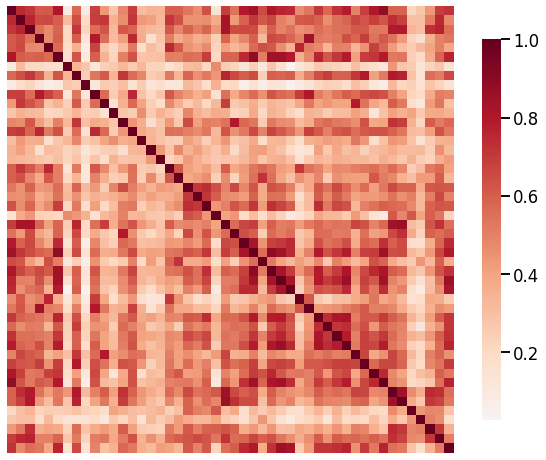

In [94]:
gp.plot.heatmap(gr)

In [96]:
gr = gp.utils.import_edgelist('/mnt/nfs2/MR/cpac_3-9-2/BNU1/graphs/FSL_nff_nsc_gsr_aal/BNU1_0025864_session_1_correlation.ssv')

<AxesSubplot:>

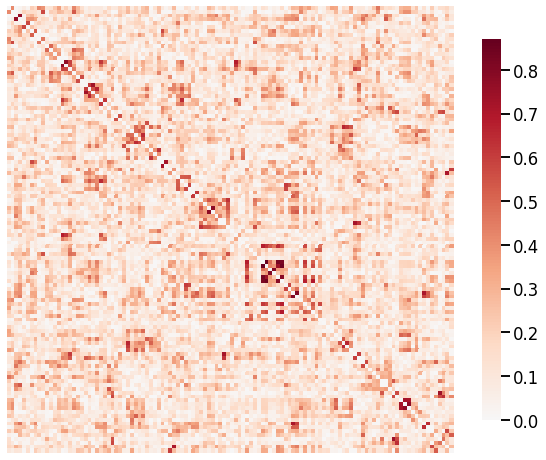

In [97]:
gp.plot.heatmap(gr)

In [86]:
np.mean(gr[des_diag == 2])

0.3150974079487933

In [87]:
gr[des_diag == 1]

array([0.05709148, 0.20354552, 0.23764867, 0.14005853, 0.24301216,
       0.02544742, 0.26542498, 0.08026262, 0.42535921, 0.59641397,
       0.25235528, 0.1855652 , 0.24244227, 0.32926114, 0.29105896,
       0.46400636, 0.3315207 , 0.19195894, 0.30589424, 0.32266887,
       0.45379793, 0.24748964, 0.57196562, 0.27805028, 0.39209525,
       0.05618904, 0.45047369, 0.35732944, 0.45485117, 0.49227029,
       0.4289881 , 0.33477755, 0.43839227, 0.07314323, 0.27991831,
       0.05709148, 0.20354552, 0.23764867, 0.14005853, 0.24301216,
       0.02544742, 0.26542498, 0.08026262, 0.42535921, 0.59641397,
       0.25235528, 0.1855652 , 0.24244227, 0.32926114, 0.29105896,
       0.46400636, 0.3315207 , 0.19195894, 0.30589424, 0.32266887,
       0.45379793, 0.24748964, 0.57196562, 0.27805028, 0.39209525,
       0.05618904, 0.45047369, 0.35732944, 0.45485117, 0.49227029,
       0.4289881 , 0.33477755, 0.43839227, 0.07314323, 0.27991831])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])